In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [68]:
df = pd.read_excel('wb_rain_fin.xls')
df['Timestamp'] = pd.to_datetime(df['Year'].astype(str), format='%Y')
#df.rename(index=str, columns={"Monthly Consumption of Type A Medicine": "count"}, inplace = True)
df.index = df.Timestamp
df.drop(['Year','Timestamp'], axis = 1, inplace = True)
df.head()

,Avg
Timestamp,
1901-01-01,372.917647
1902-01-01,561.247059
1903-01-01,424.311765
1904-01-01,382.917647
1905-01-01,530.300000


In [69]:
df.tail(5)

,Avg
Timestamp,
2013-01-01,424.611765
2014-01-01,409.864706
2015-01-01,444.452941
2016-01-01,463.200000
2017-01-01,473.800000


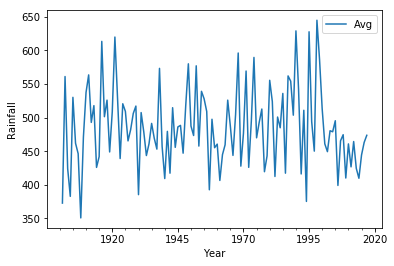

In [70]:
df.plot()
plt.ylabel('Rainfall')
plt.xlabel('Year')
plt.show()

In [71]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [72]:
train_data = df['1901-01-01':'2016-01-01']
test_data = df['2016-01-01':'2017-01-01']

In [73]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [74]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 730.801060049066 for model SARIMAX(3, 1, 1)x(3, 1, 1, 12)


In [75]:
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [76]:
pred0 = results.get_prediction(start='2017-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [77]:
pred1 = results.get_prediction(start='2017-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [78]:
pred2 = results.get_forecast('2025-01-01')
pred2_ci = pred2.conf_int()

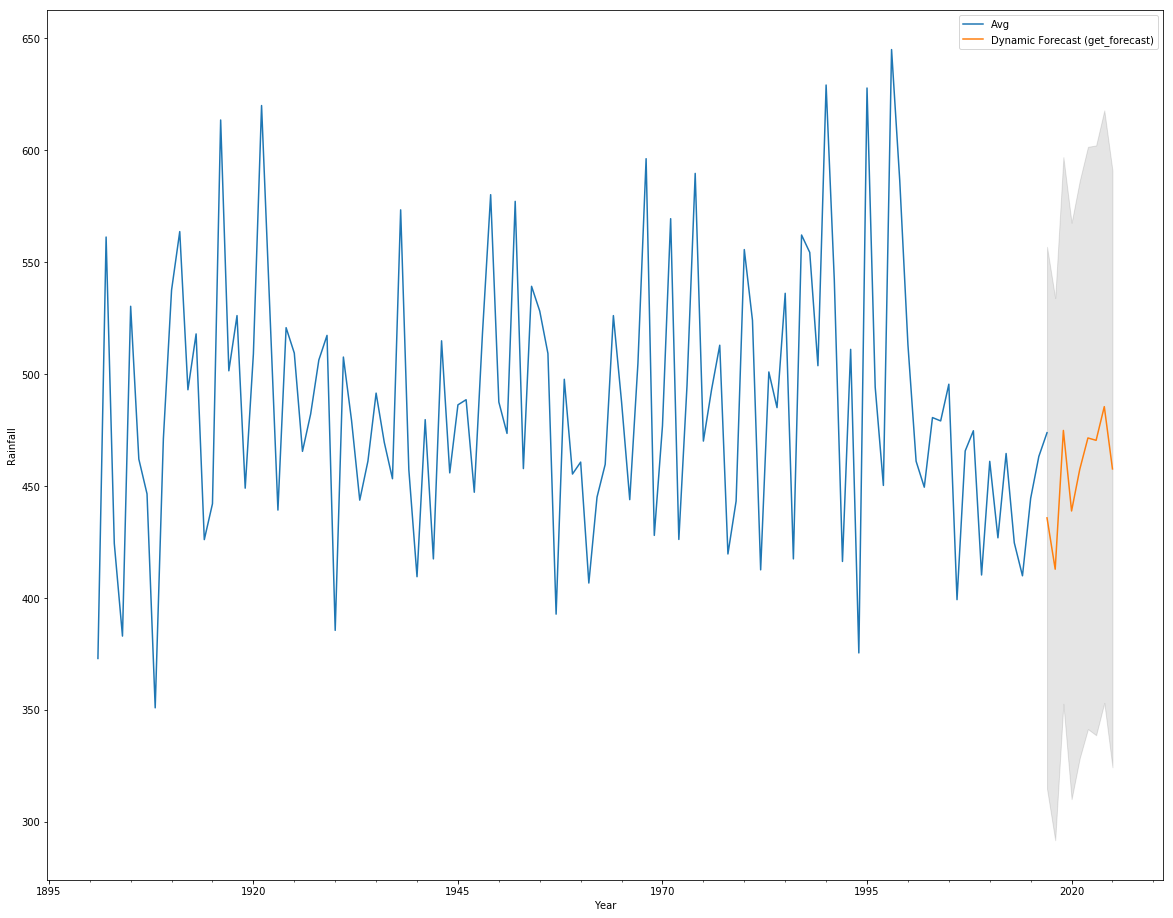

In [79]:
ax = df.plot(figsize=(20, 16))
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Rainfall')
plt.xlabel('Year')
plt.legend()
plt.show()


In [80]:
prediction = pred2.predicted_mean['2016-01-01':'2017-01-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 2017 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 2017 is 6.98%


In [16]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [17]:
fit1 = ExponentialSmoothing(np.asarray(train_data['Avg']) ,seasonal_periods=1 ,trend='add', seasonal='add',).fit()
prediction = fit1.forecast(5)

ValueError: operands could not be broadcast together with shapes (100,) (0,) 

In [29]:
prediction

array([1843.78799192, 2283.10946893, 2541.12308143, 2869.89544993,
       3232.56566158, 3731.05571907, 3119.89101372, 2940.80419953,
       2735.55047826, 2560.04556385, 2415.36020744, 2202.65267107])

In [30]:
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 2017 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 2017 is 5.20%


In [81]:
preds = pred2.predicted_mean['2018-01-01':'2025-01-01'].values

In [83]:
data = {'Year': range(2018,2026, 1), 'Avg': preds}
pred_wb = pd.DataFrame(data = data)
pred_wb.head(5)

,Year,Avg
0,2018,412.806242
1,2019,474.817284
2,2020,438.829731
3,2021,457.408547
4,2022,471.459587


In [84]:
pred_wb.to_csv('pred_wb.csv', index = False)